#### <b>1. 녹내장 이미지 학습을 위한 데이터 분류</b>

* 이미지를 분류하기 위해 디렉터리를 생성하고 필요한 함수를 정의합니다.

#### <b>2. PyTorch를 이용한 전이 학습(Transfer Learning)</b>

* 전이 학습(transfer learning)의 동작 과정을 간략화한 것은 다음과 같습니다.

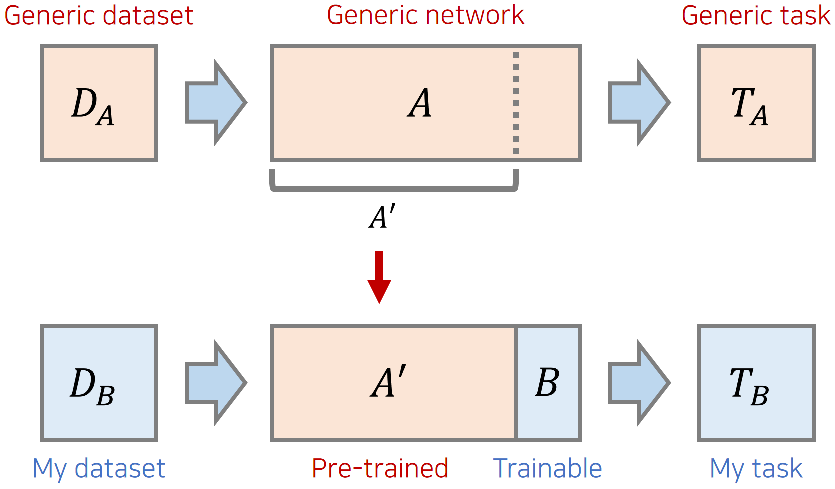

* 학습을 위해 필요한 라이브러리를 불러옵니다.

In [1]:
import os
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torchvision import datasets, models, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [2]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

data_dir = './512resized_images'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 3168
테스트 데이터셋 크기: 792
클래스: ['0', '1', '2']


* 간단히 이미지를 시각화해 봅시다.

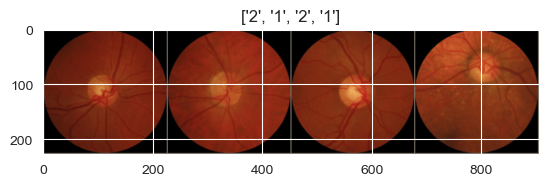

In [3]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()

# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [4]:
model = models.GoogLeNet()
print(model)

/Users/hansanghyeon/anaconda3/lib/python3.11/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [5]:
num_features = model.fc.in_features

# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

model.aux_logits = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

* 학습을 진행합니다.

In [6]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    
    # 학습 과정 중에 결과 출력
    print('# {} Loss: {:.4f} | Acc: {:.4f}% | Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() - start_time))

# 1 Loss: 1.1156 | Acc: 39.7727% | Time: 211.9098s
# 2 Loss: 1.0642 | Acc: 43.5922% | Time: 439.8897s
# 3 Loss: 1.0715 | Acc: 42.5821% | Time: 664.1443s
# 4 Loss: 1.0215 | Acc: 47.5063% | Time: 888.0310s
# 5 Loss: 1.0114 | Acc: 48.2955% | Time: 1112.7486s
# 6 Loss: 0.9962 | Acc: 49.5896% | Time: 1337.2368s
# 7 Loss: 0.9715 | Acc: 51.3889% | Time: 1563.6338s
# 8 Loss: 0.9472 | Acc: 53.8510% | Time: 1795.1310s
# 9 Loss: 0.9376 | Acc: 54.1035% | Time: 2022.4941s
# 10 Loss: 0.9194 | Acc: 54.8927% | Time: 2248.0660s
# 11 Loss: 0.8872 | Acc: 58.7437% | Time: 2475.5471s
# 12 Loss: 0.8567 | Acc: 59.8800% | Time: 2706.4895s
# 13 Loss: 0.8376 | Acc: 62.2475% | Time: 2936.6004s
# 14 Loss: 0.8111 | Acc: 63.7942% | Time: 3163.3505s
# 15 Loss: 0.7987 | Acc: 64.5833% | Time: 3354.6247s
# 16 Loss: 0.7655 | Acc: 65.6250% | Time: 3545.7655s
# 17 Loss: 0.7246 | Acc: 68.8447% | Time: 3738.2072s
# 18 Loss: 0.7187 | Acc: 68.7500% | Time: 3931.0598s
# 19 Loss: 0.6955 | Acc: 70.7071% | Time: 4123.7782s
# 20 L

* 학습된 모델을 평가합니다.

In [7]:
model.eval()
start_time = time.time()

# 모델을 평가할 때 사용할 변수 초기화
y_true = []  # 실제 레이블을 저장할 리스트
y_pred = []  # 모델의 예측 결과를 저장할 리스트
y_pred_perfom = []

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        probabilities = torch.softmax(outputs, dim=1)  # 소프트맥스를 통해 확률값으로 변환

        # 실제 레이블과 모델의 예측 확률을 리스트에 추가 (ROC curve, AUC)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(probabilities.cpu().numpy())

        # 실제 레이블과 모델의 예측 결과를 리스트에 추가 (Performance)
        y_pred_perfom.extend(preds.cpu().numpy())
        
    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[Test Phase] Loss: 0.0711 Acc: 96.7172% Time: 43.9866s


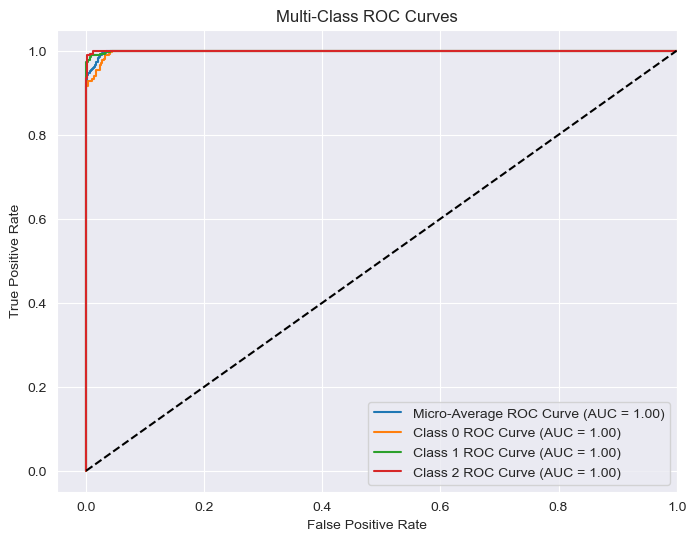

In [8]:
# 각 클래스에 대한 ROC 커브 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_pred)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 모든 클래스의 평균 ROC 커브 및 평균 AUC 계산
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(np.array(y_true), classes=np.arange(len(class_names))).ravel(),
                                          np.array(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC 커브 및 AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-Average ROC Curve (AUC = {roc_auc['micro']:.2f})")

for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} ROC Curve (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves")
plt.legend(loc="lower right")
plt.show()

---
### 성능 평가 지표

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score

In [10]:
accuracy = accuracy_score(y_true, y_pred_perfom)
print(f"Multi-Class Accuracy: {accuracy * 100:.2f}%")

Multi-Class Accuracy: 96.72%


In [11]:
# classification_report 출력
target_names = class_names
print("Classification Report")
print(classification_report(y_true, y_pred_perfom, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       264
           1       0.94      0.99      0.97       264
           2       1.00      0.96      0.98       264

    accuracy                           0.97       792
   macro avg       0.97      0.97      0.97       792
weighted avg       0.97      0.97      0.97       792


### Multi-Confusion matrix
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FYz4fi%2Fbtqyd71KPB4%2F5B95l7uJvIT8eheYMyd2A1%2Fimg.png" width="1000" height="606">

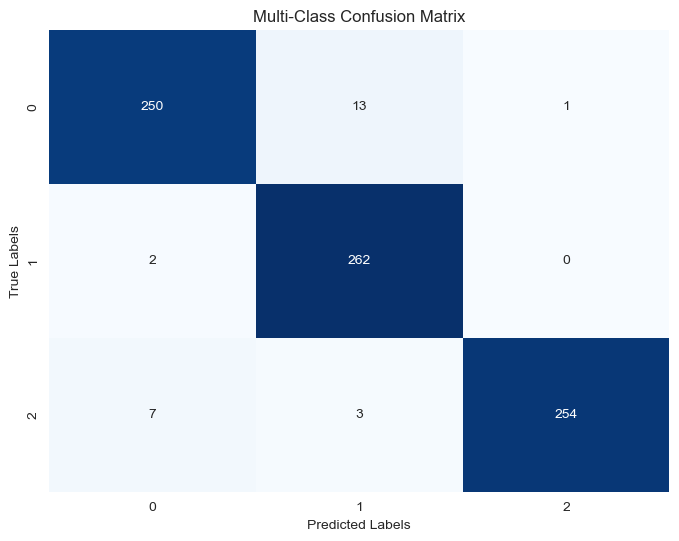

In [12]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_perfom)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Multi-Class Confusion Matrix")
plt.show()

In [13]:
# 카파 통계량 계산
kappa = cohen_kappa_score(y_true, y_pred_perfom)

print(f'Cohen\'s Kappa: {kappa:.4f}')

Cohen's Kappa: 0.9508


---

In [14]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,